# Recommendation Methods: 


### Alg 0: Most similar items to user's previous views 

Offline: 
1. For each item, calculate features on trained neural network $ f_j $
2. For each user, look up previous views and average the features together of the previous visit $ f_i = \sum_j f_j*I(i,j) $
3. Store the features of the 'typical' item viewed by this user. 
4. Calculate similarity of all items to user's 'typical item', store as a recommend list

Online: 
1. User comes to website
2. Recommend the top 20 items from his recommend list. 





In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

In [28]:
import sys
import os
sys.path.append('../')
os.getcwd()

'/Users/chris/Desktop/CDIPS_Recommender/notebooks'

In [39]:
import src
import src.recommendation
reload(src.recommendation)
from src.recommendation import *



# Recommendation Comparison


- A more general framework for comparing different recommendation techniques

### Evaluation DataSet

See notes in the creating_dataset_for_evaluation.ipynb

From full dataset
- removed rows with no nn features (for view or for buy)
- remove the items that have been viewed 20minutes before buying. 
- sub-sampled a set of 1000 users


In [18]:
# load smaller user behavior dataset
user_profile = pd.read_pickle('../data_user_view_buy/user_profile_items_nonnull_features_20_mins_5_views_v2_sample1000.pkl')
user_sample = user_profile.user_id.unique()
print(len(user_profile))
print(len(user_sample))
user_profile.head()


40141
961


,user_id,buy_spu,buy_sn,buy_ct3,view_spu,view_sn,view_ct3,time_interval,view_cnt,view_seconds,index,spu_id,view_spu_count,drop
1226,3787002243,14994645517246498,10006541,334,221597279072104476,10005949,334,389705,4,98,87616.0,2.215973e+17,11,0
1227,3787002243,14994645517246498,10006541,334,29349802448457744,10004542,334,7342,1,10,73880.0,2.934980e+16,11,0
2261,132681117,6831894477217820,10001155,334,27661017974767638,10004048,334,32451,1,6,21676.0,2.766102e+16,63,0
2262,132681117,6831894477217820,10001155,334,288869796837830741,10000351,334,33318,2,30,6475.0,2.888698e+17,63,0
2263,132681117,6831894477217820,10001155,334,301817675098247170,10020640,334,428149,1,9,25612.0,3.018177e+17,63,0


In [19]:
# requires nn features 
spu_fea = pd.read_pickle("../data_nn_features/spu_fea_sample1000.pkl")

In [20]:
# make sure all items have features ?? One missing
print(len(set(list(user_profile.buy_spu.unique())+list(user_profile.view_spu.unique()))))
print(len(spu_fea.spu_id.unique()))

17988
17987


### Load precalculated things for recommendations

In [10]:
# this might be faster #

# ## Precalculate average feature per user
# average_viewed_features_dict = {}

# for user_id in user_profile.user_id.unique():
#     average_viewed_features_dict[user_id] = get_user_average_features(user_id,user_profile,spu_fea)
    

### Loop through users and score function

In [21]:
def get_user_buy_ranks(users_sample,user_profile,spu_fea,method,randomize_scores=False):
    
    user_buy_ranks = np.empty(len(users_sample))
    no_ranks = np.empty(len(users_sample))
    for ui,user_id in enumerate(users_sample):
        print(ui)
        
        # rank items
        item_score_in_category = rank_candidates(user_id,user_profile,spu_fea,method=method,extra_inputs={},randomize_scores=randomize_scores)
    
        # get bought item rank and store into array 
        user_buy_ranks[ui]=item_score_in_category.loc[item_score_in_category.buy==1,'rank'].as_matrix()[0]
        
        # get number of ranks per category 
        no_ranks[ui]=item_score_in_category['rank'].max()
        
    return(user_buy_ranks,no_ranks,item_score_in_category)

### Evaluate Different Algorithms

In [22]:
users_sample = np.random.choice(user_sample,size=50)


In [23]:
# nathan's
user_buy_ranks1,no_ranks1,item_score_in_category=get_user_buy_ranks(users_sample,user_profile,spu_fea,method='AverageFeatureSim')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
missing a candidates features ui:888019272 spu:289151275262005248
37
38
39
40
41
42
43
44
45
46
47
48
49


In [40]:
# just taking the last item 
user_buy_ranks2,no_ranks2,_=get_user_buy_ranks(users_sample,user_profile,spu_fea,method='LastItemSim')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
missing a candidates features ui:888019272 spu:289151275262005248
37
38
39
40
41
42
43
44
45
46
47
48
49


In [43]:
# randomize 
user_buy_ranks3,no_ranks3,_=get_user_buy_ranks(users_sample,user_profile,spu_fea,method='Randomize',randomize_scores=True)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [44]:
# stack
rank_percent = np.vstack((user_buy_ranks1/no_ranks1,user_buy_ranks2/no_ranks2,user_buy_ranks3/no_ranks3))
print(rank_percent.shape)

(3, 50)


50
3


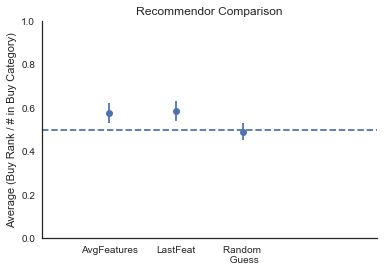

In [47]:
# Plot 
mean = rank_percent.mean(axis=1)
n = np.shape(rank_percent)[1]
m = np.shape(rank_percent)[0]
print(n)
print(m)

sem = rank_percent.std(axis=1)/np.sqrt(n)
plt.errorbar(np.arange(m),y=mean,yerr=sem,linestyle='None',marker='o')
plt.xticks(np.arange(m),['AvgFeatures','LastFeat','Random \n Guess'])
plt.xlim([-1,m+1])
plt.ylim(0,1)
sns.despine()
plt.title('Recommendor Comparison')
plt.ylabel('Average (Buy Rank / # in Buy Category)')
plt.axhline(y=0.5,linestyle='--')
savefile = '../figures/recommender_comparison_sample_1000_subsample50_v1.png'
plt.savefig(savefile,dpi=300)

In [49]:
from src import s3_data_management
s3_data_management.push_results_to_s3(os.path.basename(savefile),savefile)

......
https://s3-us-west-2.amazonaws.com/bishopbucket/proj_cdips/Results/recommender_comparison_sample_1000_subsample50_v1.png


# Save

In [ ]:
%%bash 
jupyter nbconvert --to slides Recommendation_Compare_Methods.ipynb && mv Recommendation_Compare_Methods.slides.html ../notebook_slides/Recommendation_Compare_Methods_v1.slides.html
jupyter nbconvert --to html Recommendation_Compare_Methods.ipynb && mv Recommendation_Compare_Methods.html ../notebook_htmls/Recommendation_Compare_Methods_v1.html
cp Recommendation_Compare_Methods.ipynb ../notebook_versions/Recommendation_Compare_Methods_v1.ipynb